In [1]:
from ttp_solvers.data import read_data
import ttp_solvers.local_search as local_search 
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
%matplotlib inline

In [55]:
def plot_ttp(ax, solution, points, color_str):
    solution, length = solution[0].flatten(), solution[1]
    ax.set_title(f"{length}")
    ax.scatter(points[:, 0], points[:, 1])
    for index_point, point in enumerate(points):
        ax.annotate(
            index_point,
            (point[0], point[1]),
            fontsize=15,
            textcoords="offset points",
            xytext=(5, 10),
        )
    data_x, data_y = [], []
    for index_element, element in enumerate(solution):
        next_element = solution[0]
        if index_element < len(solution) - 1:
            next_element = solution[index_element + 1]
        data_x, data_y = points[element]
        delta_x, delta_y = (points[next_element] - points[element])
        ax.arrow(data_x, data_y, delta_x, delta_y, width=0.005, color=color_str)

In [3]:
DATA_PATH = "../data/tsp_51_1"

In [4]:
points = None
with open(DATA_PATH, "r") as input_data_file:
    input_data = input_data_file.read()
    points = read_data(input_data)

In [5]:
def compute_length(solution, distance_array):
    flattened_solution = solution.flatten()
    solution_temp = np.hstack([flattened_solution, flattened_solution[0]])
    return (
        sum(
            distance_array[
                int(solution_temp[elem_index]), 
                int(solution_temp[elem_index+1])
            ]
            for elem_index, _ in enumerate(solution_temp[:-1])
        )
    )

In [6]:
distance_array = local_search.build_distance_matrix(points)

In [9]:
def get_subpath(state, center, length):
    state = state.flatten()
    if (2*length + 1) > len(state):
        raise ValueError("Length of the subpath is longer than the all state")
        
    subpath = np.array(center)
    index_center = np.where(state == center)[0]
    
    for i in range(length):
        index_previous = index_center - (i+1)
        index_next = index_center + (i+1)
    
        if index_next > (len(state) -1):
            index_next = (index_next - len(state))
        subpath = np.hstack([state[index_previous], subpath, state[index_next]])
    return subpath


def symetry_breaking(solution):
    solution = solution.flatten()
    zero_index = np.argsort(solution)[0]
    next_index = zero_index + 1 if zero_index < (len(solution) - 1) else 0
    last_index = zero_index - 1

    if solution[next_index] > solution[last_index]:
        solution = solution[::-1]

    zero_index = np.argsort(solution)[0]

    return np.hstack([solution[zero_index:], solution[:zero_index]]).reshape(
        1, len(solution)
    )

# Study of the selfish 2 opt neighborhood

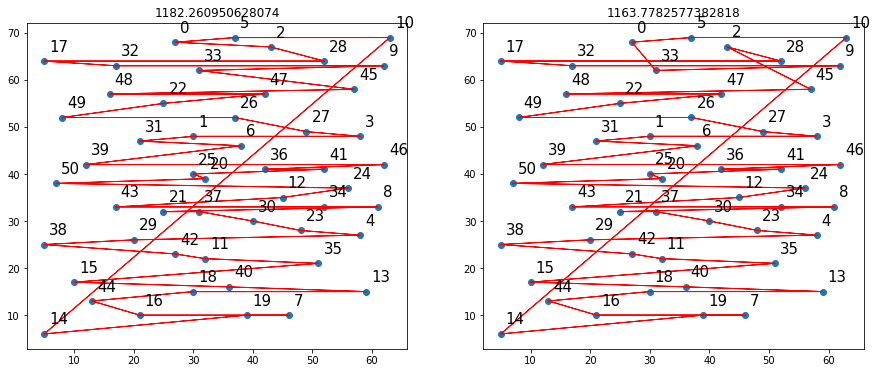

In [91]:
def get_closest_point(subpath, distance_array):
    closest_index = np.argsort(distance_array[subpath[1], :])
    
    check_elem_list = [subpath[0], subpath[2]]
    reverse_state = False
    for index in [1, 2, 3]:
        if closest_index[index] in check_elem_list:
            if closest_index[index] != check_elem_list[0]:
                reverse_state = True
                check_elem_list.pop(1)
            else:
                check_elem_list.pop(0)
        else:
            if check_elem_list:
                return closest_index[index], reverse_state 
            else:
                return None
    return None

def selfish_two_opt(state, distance_array, center):
    flatten_state = state.flatten()
    
    subpath = get_subpath(flatten_state, center, 1)
    
    if (replacement := get_closest_point(subpath, distance_array)) is None:
        return None
    else:
        new_next_elem, reverse = replacement
        correct_direction_state = flatten_state[::-1] if reverse else flatten_state

        index_center = np.where(correct_direction_state == center)[0][0]
        ravel_state = np.hstack([correct_direction_state[index_center:], correct_direction_state[:index_center]])
        
        end = np.where(ravel_state == new_next_elem)[0][0]

        return symetry_breaking(
                np.hstack([ravel_state[0], ravel_state[1:end+1][::-1], ravel_state[end+1:]]).astype(int)
            )
        
next_state = symetry_breaking(np.argsort(points[:, 1]))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_ttp(axes[0], (next_state.flatten(), compute_length(next_state, distance_array)), points, "red")

next_state = selfish_two_opt(next_state, distance_array, 0)
plot_ttp(axes[1], (next_state.flatten(), compute_length(next_state, distance_array)), points, "red")
plt.show()

# Study of the 2 opt neighborhood

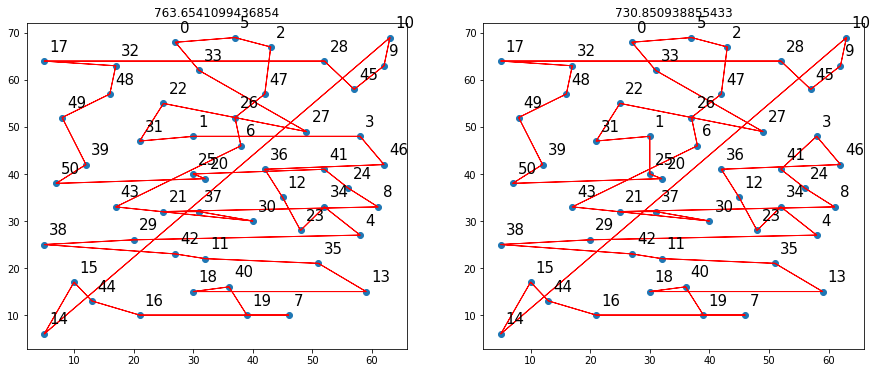

In [75]:
def get_closest_next_point(nodes_pairs, distance_array, center):
    for nodes_pair in nodes_pairs:
        point_lengths_index = np.argsort(distance_array[nodes_pair[0], :])
        if (center == point_lengths_index[1]):
            continue
        elif (nodes_pair[1] == point_lengths_index[1]):
            if point_lengths_index[2] == center:
                return None
            else:
                return nodes_pair[0], point_lengths_index[2], nodes_pair[2]
        else :
            return nodes_pair[0], point_lengths_index[1], nodes_pair[2]
    return None

def two_opt(state, distance_array, center):
    flatten_state = state.flatten()
    
    subpath = get_subpath(flatten_state, center, 2)
    
    study_pairs = [(subpath[1],subpath[0], True), (subpath[3],subpath[4], False)]
    if distance_array[subpath[2], subpath[1]] > distance_array[subpath[2], subpath[3]]: 
        study_pairs = study_pairs[::-1]
    
    if (next_node_pair := get_closest_next_point(study_pairs, distance_array, center)) is None:
        return None
    else:
        correct_direction_state = flatten_state[::-1] if next_node_pair[2] else flatten_state
        
        index_center = np.where(correct_direction_state == center)[0][0]
        
        ravel_state = np.hstack([correct_direction_state[index_center:], correct_direction_state[:index_center]])
        end = np.where(ravel_state == next_node_pair[1])[0][0]
        
        tabu.append(next_node_pair[0])
        return (
            symetry_breaking(
                np.hstack([ravel_state[0], ravel_state[1:end][::-1], ravel_state[end:]]).astype(int)
            )
        )
    
next_state = SAVE_STATE

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_ttp(axes[0], (next_state.flatten(), compute_length(next_state, distance_array)), points, "red")

next_state = two_opt(next_state, distance_array, 3)
plot_ttp(axes[1], (next_state.flatten(), compute_length(next_state, distance_array)), points, "red")
plt.show()

# Study of the uncrossing swap neighborhood

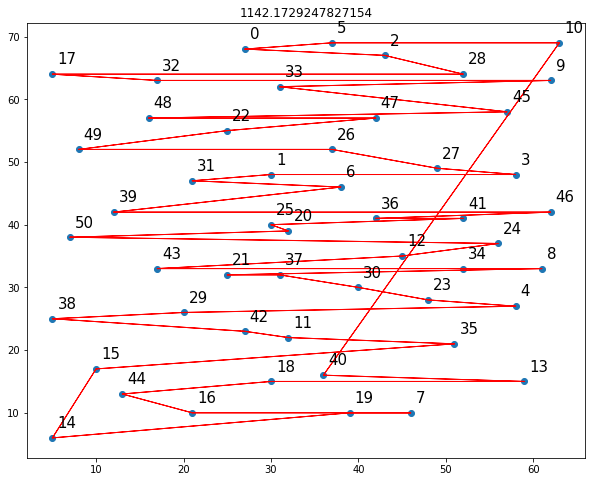

In [305]:
from numpy.lib.stride_tricks import sliding_window_view

def slope(index_0, index_1, points):
    if points[index_0][0] == points[index_1][0]:
        return np.nan
    else : 
        return (points[index_1][1] - points[index_0][1])/(points[index_1][0] - points[index_0][0])

def crossing(segment_0, segment_1, points):
    origin_0, dest_0, slope_0 = points[segment_0[0], :], points[segment_0[1], :], slope(segment_0[0], segment_0[1], points) 
    origin_1, dest_1, slope_1 = points[segment_1[0], :], points[segment_1[1], :], slope(segment_1[0], segment_1[1], points)
    
    intersect_x = None
    if np.isnan(slope_0):
        if not np.isnan(slope_1):
            if slope_1 == 0:
                return (origin_1[1] - origin_0[1]) * (origin_1[1] - dest_0[1]) < 0
            else:
                intersect_x =  (origin_0[0] - origin_1[1]) / slope_1 
    elif np.isnan(slope_1):
        if not np.isnan(slope_0):
            if slope_0 == 0:
                return (origin_0[1] - origin_1[1]) * (origin_0[1] - dest_1[1]) < 0
            else :
                intersect_x = (origin_1[0] - origin_0[1]) / slope_0 
    elif slope_0 == slope_1:
        return False
    else:
        intersect_x = (slope_0*origin_0[0] - slope_1*origin_1[0] - origin_0[1] + origin_1[1])/(slope_0 - slope_1)
        #print(segment_0, segment_1, intersect_x, (intersect_x - origin_0[0]) * (intersect_x - dest_0[0]))
    return False if intersect_x is None else ( 
        (intersect_x - origin_0[0]) * (intersect_x - dest_0[0]) < -1E-6 and
        (intersect_x - origin_1[0]) * (intersect_x - dest_1[0]) < -1E-6
    )
    
def cross_neighborhood(state, points, center):
    flatten_state = state.flatten()
    
    subpath = get_subpath(flatten_state, center, 1)
    
    sliding_windows = sliding_window_view(np.hstack([flatten_state, flatten_state[0]]), window_shape=2)
    
    crossings = []
    for segment in [subpath[:2], subpath[1:]]:
        
        cross_segments = np.apply_along_axis(lambda x: crossing(segment, x, points), 1, sliding_windows)
        crossings_index = np.where(cross_segments)
        
        crossings.append(
            np.hstack(
                [
                    np.repeat(segment.reshape(1, 2), repeats=len(crossings_index[0]), axis=0), 
                    sliding_windows[crossings_index, :][0]
                ]
            )
        )
    neighbor_crossings = np.vstack(crossings)
    neighbors = np.zeros((len(neighbor_crossings), len(flatten_state)))
    
    for index, row in enumerate(neighbor_crossings):
        index_center = np.where(flatten_state == row[0])[0][0]
        ravel_state = np.hstack([flatten_state[index_center:], flatten_state[:index_center]])
        end = np.where(ravel_state == row[3])[0][0]
        neighbors[index, :] = symetry_breaking(
            np.hstack([ravel_state[0], ravel_state[1:end][::-1], ravel_state[end:]])
        ).flatten()
    
    return neighbors.astype(int)
    
                        
next_state = symetry_breaking(np.argsort(points[:, 1]))

neighbors = np.vstack([next_state, cross_neighborhood(next_state, points, 10)])

from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10, 8))
def animate(i):
    ax.cla()
    plot_ttp(ax, (neighbors[i, :], compute_length(neighbors[i, :], distance_array)), points, "red")

ani = matplotlib.animation.FuncAnimation(
    fig, 
    animate, 
    frames=int(len(neighbors))
)
HTML(ani.to_jshtml())

# Greedy approach with the 2 two opt neighborhood and crossing

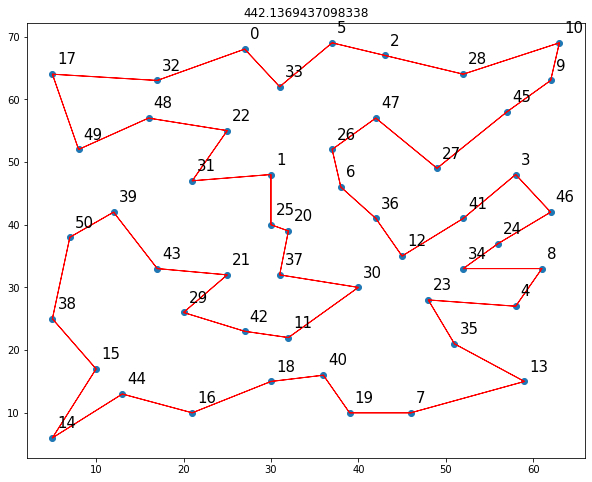

In [307]:
initial_state = symetry_breaking(np.argsort(points[:, 1]))
solutions = []
best_solutions = []

solution, length = initial_state, compute_length(initial_state, distance_array)
solutions.append((solution, length))

for iteration in range(100):
    node_index, neighbors = 0, []
    
    for node_index in range(len(points)):
        if (neighbor := two_opt(solution, distance_array, node_index)) is not None:
            neighbors.append(neighbor)
        if (neighbor := selfish_two_opt(solution, distance_array, node_index)) is not None:
            neighbors.append(neighbor)
        if (neighbor := cross_neighborhood(solution, points, node_index)) is not None:
            neighbors.append(neighbor)
    if not neighbors:
        print("NO VALID NEIGHBORS", iteration)
    else: 
        neighbors = np.vstack(neighbors)
        trip = np.apply_along_axis(
            lambda x: compute_length(x, distance_array),
            1,
            neighbors
        )
        chosen_index = np.argsort(trip)[0]
        
        if trip[chosen_index] > length:
            break
            
        solution, length = neighbors[chosen_index, :].astype(int), trip[chosen_index]

        solutions.append((solution, length))
        
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10, 8))
def animate(i):
    ax.cla()
    plot_ttp(ax, solutions[i], points, "red")

ani = matplotlib.animation.FuncAnimation(
    fig, 
    animate, 
    frames=int(len(solutions))
)
HTML(ani.to_jshtml())

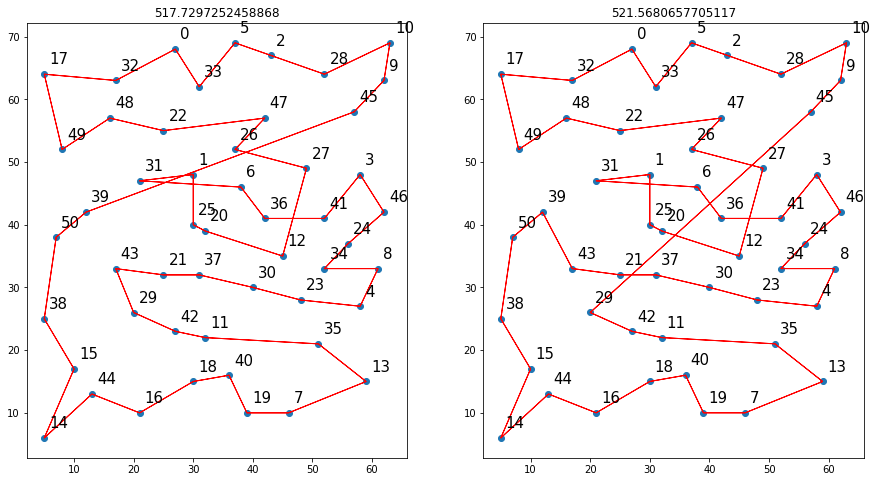

In [94]:
next_state = selfish_two_opt(solutions[-1][0], distance_array, 39)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plot_ttp(axes[0], solutions[-1], points, "red")
plot_ttp(axes[1], (next_state, compute_length(next_state, distance_array)), points, "red")
plt.show()

# Simulated Annealing

In [113]:
initial_state = symetry_breaking(np.argsort(points[:, 1]))
solutions = []
best_solutions = []

solution, length = initial_state, compute_length(initial_state, distance_array)
solutions.append((solution, length))

BEST_SOLUTION, LENGTH = None, None
temperature = 10

for temperature in [100, 10, 1, 0, 10, 1, 0]:
    for iteration in range(100):
        node_index, neighbors = 0, []

        for node_index in range(len(points)):
            if (neighbor := two_opt(solution, distance_array, node_index)) is not None:
                neighbors.append(neighbor)
            if (neighbor := selfish_two_opt(solution, distance_array, node_index)) is not None:
                neighbors.append(neighbor)
        if not neighbors:
            print("NO VALID NEIGHBORS", iteration)
        else: 
            neighbors = np.vstack(neighbors)
            neighbors = neighbors[np.random.permutation(neighbors.shape[0]), :]
            trip = np.apply_along_axis(
                lambda x: compute_length(x, distance_array),
                1,
                neighbors
            )
            if temperature == 0:
                chosen_index = np.argsort(trip)[0]
                if trip[chosen_index] > length:
                    break
                solution, length = neighbors[chosen_index, :].astype(int), trip[chosen_index]

                if BEST_SOLUTION is None or LENGTH > length:
                    BEST_SOLUTION, LENGTH = solution, length
                solutions.append((solution, length))
            else:
                annealing = np.exp((length-trip)/temperature)
                check = annealing > np.random.rand(len(annealing))
                if np.sum(check) != 0:
                    check = annealing > np.random.rand(len(annealing))
                    chosen_index = np.argsort(check)[0]

                    solution, length = neighbors[chosen_index, :].astype(int), trip[chosen_index]

                    if BEST_SOLUTION is None or LENGTH > length:
                        BEST_SOLUTION, LENGTH = solution, length
                    solutions.append((solution, length))

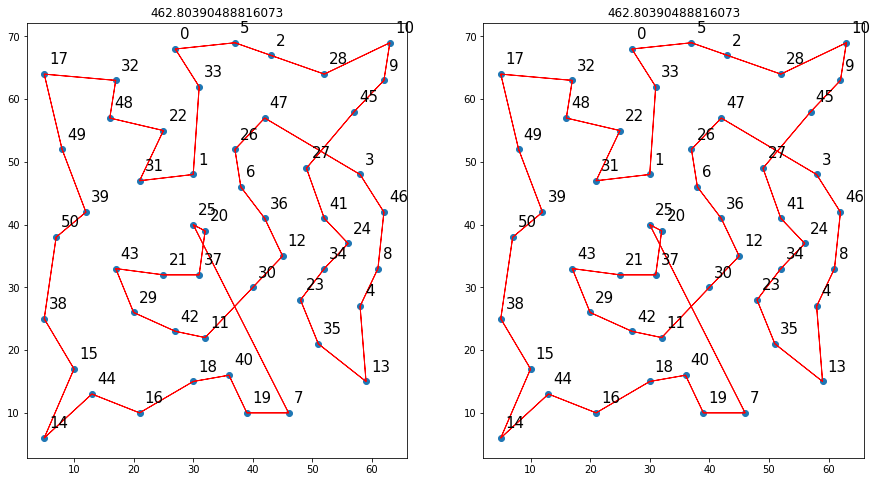

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plot_ttp(axes[0], solutions[-1], points, "red")
plot_ttp(axes[1], (BEST_SOLUTION, LENGTH), points, "red")
plt.show()

# Study of the k-opt neighborhood

In [ ]:
def k_opt(initial_state, distance_array, node):
    next_state, tabu = initial_state, []
    neighbors = []
    while (result := two_opt(next_state, distance_array, node, tabu)) is not None:
        (next_state, tabu) = result
        neighbors.append(next_state)
    
    if neighbors:
        return np.vstack(neighbors)
    else:
        return None
    
next_state = symetry_breaking(np.argsort(points[:, 1]))

fig, ax = plt.subplots(figsize=(6, 6))
plot_ttp(ax, next_state.flatten(), points, "red")
plt.show()

save_state, tabu = initial_state, []

while (result := two_opt(next_state, distance_array, 0, tabu)) is not None:
    (next_state, tabu) = result
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_ttp(ax, next_state.flatten(), points, "red")
    plt.show()
    save_state = next_state

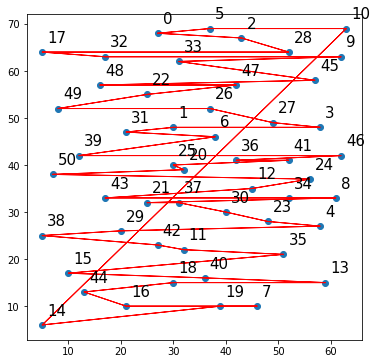

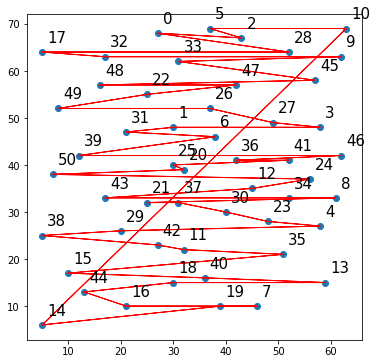

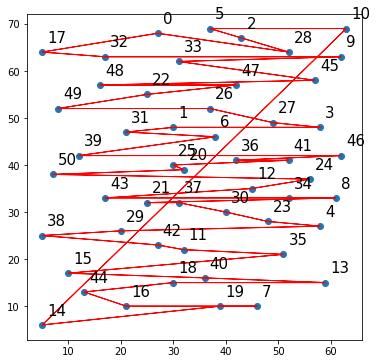

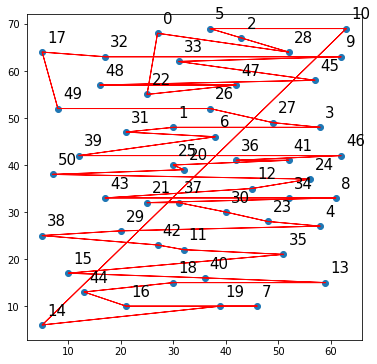

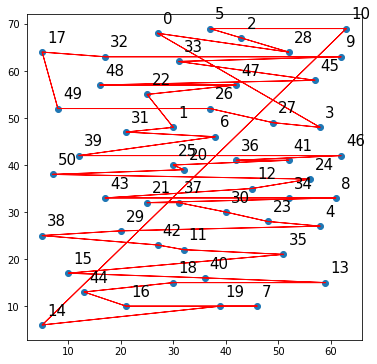

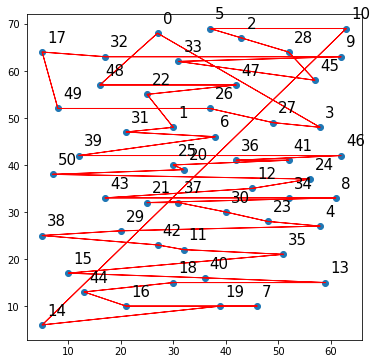

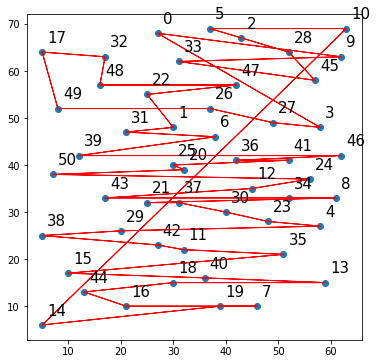

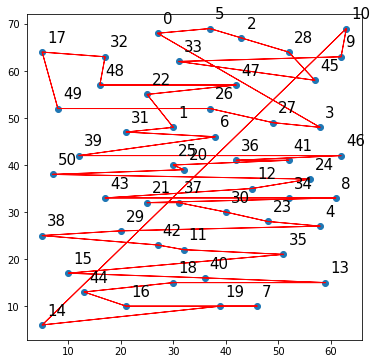

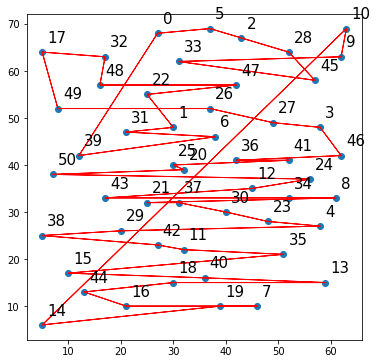

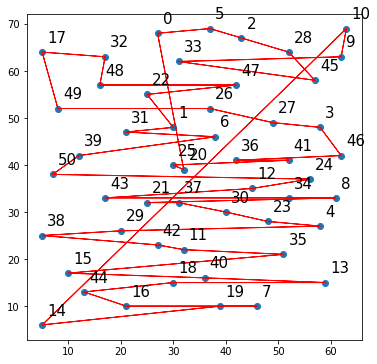

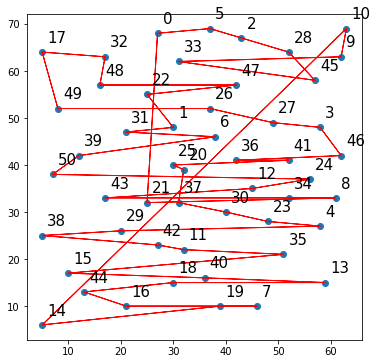

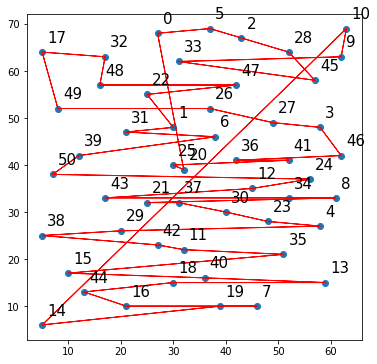

In [228]:
def get_closest_next_point(nodes_pairs, distance_array, center):
    for nodes_pair in nodes_pairs:
        point_lengths_index = np.argsort(distance_array[nodes_pair[0], :])
        if (center == point_lengths_index[1]):
            return None
        elif (nodes_pair[1] == point_lengths_index[1]):
            if point_lengths_index[2] == center:
                return None
            else:
                return nodes_pair[0], point_lengths_index[2], nodes_pair[2]
        else :
            return nodes_pair[0], point_lengths_index[1], nodes_pair[2]
    return None

def two_opt(state, distance_array, center, tabu):
    flatten_state = state.flatten()
    
    subpath = get_subpath(flatten_state, center, 2)
    node_pairs = []
    
    if not (subpath[1] in tabu):
        node_pairs.append((subpath[1],subpath[0], True))
    if not (subpath[3] in tabu):
        node_pairs.append((subpath[3],subpath[4], False))
    if (len(node_pairs) > 1) and (distance_array[subpath[2], subpath[1]] > distance_array[subpath[2], subpath[3]]): 
        node_pairs = node_pairs[::-1]
    
    if not node_pairs:
        return None
    
    if (next_node_pair := get_closest_next_point(node_pairs, distance_array, center)) is None:
        return None
    else:
        correct_direction_state = flatten_state[::-1] if next_node_pair[2] else flatten_state
        
        index_center = np.where(correct_direction_state == center)[0][0]
        
        ravel_state = np.hstack([correct_direction_state[index_center:], correct_direction_state[:index_center]])
        end = np.where(ravel_state == next_node_pair[1])[0][0]
        
        tabu.append(next_node_pair[0])
        return (
            symetry_breaking(
                np.hstack([ravel_state[0], ravel_state[1:end][::-1], ravel_state[end:]]).astype(int)
            ), tabu
        )
    
next_state = symetry_breaking(np.argsort(points[:, 1]))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_ttp(axes[0], next_state.flatten(), points, "red")

next_state, tabu = two_opt(next_state, distance_array, 0, [])
plot_ttp(axes[1], next_state.flatten(), points, "red")
plt.show()

# Study of the k opt neighborhood

In [255]:
initial_state = symetry_breaking(np.argsort(points[:, 1]))
solutions = []
best_solutions = []

solution, length = state, compute_length(initial_state, distance_array)
solutions.append(solution)

TABU = 25
tabu = [-1 for _ in range(initial_state.size)]
for iteration in range(1000):
    subpathes = [get_subpath(solution, x, 1) for x in solution.flatten()]
    longer_node_index = np.argsort(
        [distance_array[elem[1], elem[0]] + distance_array[elem[1], elem[2]] for elem in subpathes]
    )[::-1]
    node_index, neighbors = 0, None
    
    for node_index in range(initial_state.size):
        next_node = longer_node_index[node_index]
        if tabu[next_node] < iteration:
            if (neighbors := k_opt(solution, distance_array, longer_node_index[node_index])) is not None:
                tabu[next_node] = iteration + TABU
                break
    
    if neighbors is None:
        print("NO VALID NEIGHBORS", iteration)
    else: 
        trip = np.apply_along_axis(
            lambda x: compute_length(x, distance_array),
            1,
            neighbors
        )
        chosen_index = np.argsort(trip)[0]

        solution, length = neighbors[chosen_index, :].astype(int), trip[chosen_index]

        solutions.append(solution)

NO VALID NEIGHBORS 20
NO VALID NEIGHBORS 21
NO VALID NEIGHBORS 22
NO VALID NEIGHBORS 23
NO VALID NEIGHBORS 24
NO VALID NEIGHBORS 25
NO VALID NEIGHBORS 26
NO VALID NEIGHBORS 30
NO VALID NEIGHBORS 33
NO VALID NEIGHBORS 34
NO VALID NEIGHBORS 45
NO VALID NEIGHBORS 46
NO VALID NEIGHBORS 47
NO VALID NEIGHBORS 48
NO VALID NEIGHBORS 49
NO VALID NEIGHBORS 50
NO VALID NEIGHBORS 51
NO VALID NEIGHBORS 52
NO VALID NEIGHBORS 54
NO VALID NEIGHBORS 56
NO VALID NEIGHBORS 57
NO VALID NEIGHBORS 58
NO VALID NEIGHBORS 59
NO VALID NEIGHBORS 60
NO VALID NEIGHBORS 62
NO VALID NEIGHBORS 72
NO VALID NEIGHBORS 73
NO VALID NEIGHBORS 74
NO VALID NEIGHBORS 75
NO VALID NEIGHBORS 76
NO VALID NEIGHBORS 77
NO VALID NEIGHBORS 78
NO VALID NEIGHBORS 80
NO VALID NEIGHBORS 82
NO VALID NEIGHBORS 83
NO VALID NEIGHBORS 84
NO VALID NEIGHBORS 85
NO VALID NEIGHBORS 86
NO VALID NEIGHBORS 88
NO VALID NEIGHBORS 90
NO VALID NEIGHBORS 97
NO VALID NEIGHBORS 98
NO VALID NEIGHBORS 99
NO VALID NEIGHBORS 100
NO VALID NEIGHBORS 101
NO VALID

NO VALID NEIGHBORS 780
NO VALID NEIGHBORS 782
NO VALID NEIGHBORS 784
NO VALID NEIGHBORS 785
NO VALID NEIGHBORS 786
NO VALID NEIGHBORS 787
NO VALID NEIGHBORS 788
NO VALID NEIGHBORS 790
NO VALID NEIGHBORS 792
NO VALID NEIGHBORS 794
NO VALID NEIGHBORS 795
NO VALID NEIGHBORS 797
NO VALID NEIGHBORS 798
NO VALID NEIGHBORS 806
NO VALID NEIGHBORS 808
NO VALID NEIGHBORS 810
NO VALID NEIGHBORS 811
NO VALID NEIGHBORS 812
NO VALID NEIGHBORS 813
NO VALID NEIGHBORS 814
NO VALID NEIGHBORS 816
NO VALID NEIGHBORS 818
NO VALID NEIGHBORS 820
NO VALID NEIGHBORS 821
NO VALID NEIGHBORS 823
NO VALID NEIGHBORS 824
NO VALID NEIGHBORS 832
NO VALID NEIGHBORS 834
NO VALID NEIGHBORS 836
NO VALID NEIGHBORS 837
NO VALID NEIGHBORS 838
NO VALID NEIGHBORS 839
NO VALID NEIGHBORS 840
NO VALID NEIGHBORS 842
NO VALID NEIGHBORS 844
NO VALID NEIGHBORS 846
NO VALID NEIGHBORS 847
NO VALID NEIGHBORS 849
NO VALID NEIGHBORS 850
NO VALID NEIGHBORS 858
NO VALID NEIGHBORS 860
NO VALID NEIGHBORS 862
NO VALID NEIGHBORS 863
NO VALID NE

TypeError: 'float' object cannot be interpreted as an integer

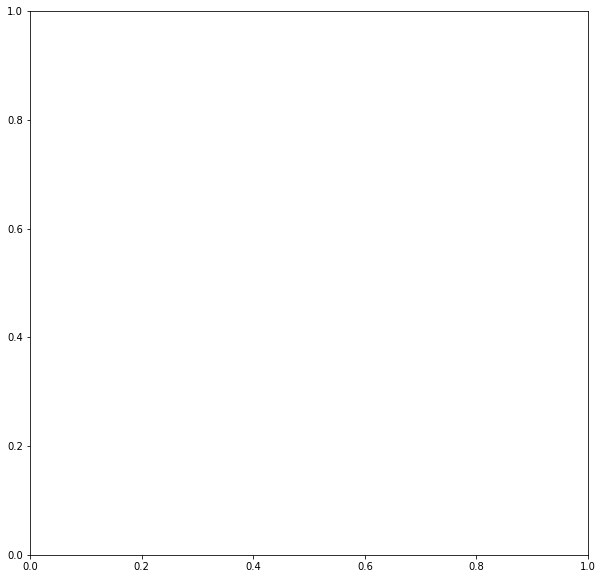

In [258]:
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10, 10))
def animate(i):
    ax.cla()
    plot_ttp(ax, solutions[i/10], points, "red")

ani = matplotlib.animation.FuncAnimation(
    fig, 
    animate, 
    frames=int(len(solutions))/10
)
HTML(ani.to_jshtml())

In [7]:
state = symetry_breaking(np.argsort(points[:, 1]))
solutions = []
best_solutions = []

solution, length = state, compute_length(state, distance_array)
solutions.append(solution)
tabu = None

temperature = 100
for iteration in range(100):
    neighbors= local_search.n_opt(solution, distance_array, 3)
    
    trip = np.apply_along_axis(
        lambda x: compute_length(x, distance_array),
        1,
        neighbors
    )
    
    
    if tabu is not None:
        while (tabu == neighbors[chosen, :].astype(int)).all(axis=1).any():
            chosen_index += 1
            chosen = annealing_order[check[annealing_order]][chosen_index]
    
    solution, length = neighbors[chosen, :].astype(int), trip[chosen]
    if tabu is None:
        tabu = solution.reshape(1, len(solution))
    else:
        tabu = np.vstack([tabu, solution])
        
    solutions.append(solution)

[[ 0  5 10 14 19  7 16 44 18 13 40 15 35 11 42 38 29  4 23 30 37 21  8 34
  43 12 24 50 20 25 41 36 46 39  6 31  1  3 27 26 49 22 47 48 45 33  9 32
  17 28  2]]
[[ 0  5 10 14 19  7 16 44 18 13 40 15 35 11 42 38 29  4 23 30 37 21  8 34
  43 12 24 50 20 25 41 36 46 39  6 31  1  3 27 26 49 22 47 48 45 33  9 32
  17 28  2]]
[[ 0  5 10 14 19  7 16 44 18 13 40 15 35 11 42 38 29  4 23 30 37 21  8 34
  43 12 24 50 20 25 41 36 46 39  6 31  1  3 27 26 49 22 47 48 45 33  9 32
  17 28  2]]
[[ 0  5 10 14 19  7 16 44 18 13 40 15 35 11 42 38 29  4 23 30 37 21  8 34
  43 12 24 50 20 25 41 36 46 39  6 31  1  3 27 26 49 22 47 48 45 33  9 32
  17 28  2]]
[[ 0  5 10 14 19  7 16 44 18 13 40 15 35 11 42 38 29  4 23 30 37 21  8 34
  43 12 24 50 20 25 41 36 46 39  6 31  1  3 27 26 49 22 47 48 45 33  9 32
  17 28  2]]
[[ 0  5 10 14 19  7 16 44 18 13 40 15 35 11 42 38 29  4 23 30 37 21  8 34
  43 12 24 50 20 25 41 36 46 39  6 31  1  3 27 26 49 22 47 48 45 33  9 32
  17 28  2]]
[[ 0  5 10 14 19  7 16 44 18 13 40

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
SAVE_STATE = np.array(
    [0,5,2,47,26,6,43,30,37,21,8,24,41,25,20,50,39,49,48,32,17,28,45,9,10,14,15,44,16,7,19,40,18,13,35,11,42,38,29,4,34,23,12,36,46,3,1,31,22,27,33]
)